### Transfer learning models:

This notebook is about transfer learning models and the reinforcement learning agent to determine whether to use the transfer learner or an active learning policy.

In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz
import src.reinforcement as rl
import src.data as d 
from src.models import logreg, CNN, AgentRL
# import active_learning as al
# import viz
# import reinforcement as rl
# import data as d 
# from models import logreg, CNN, AgentRL

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.models as tmodels
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.distributions import Categorical

%matplotlib inline

In [13]:
# Get raw datasets - MNIST
d = imp.reload(d)
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

# Get raw dataset - USPS
percent_test = 0.3
usps_batch = 64
usps_set = d.get_usps('usps/usps_all.mat', size=(28,28))
usps_x, usps_y, usps_test_x, usps_test_y = al.get_dataset_split(usps_set,int(len(usps_set)*percent_test))
usps_test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_test_x, usps_test_y), \
                                               batch_size=len(usps_test_y),shuffle=False)
usps_train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_x, usps_y), \
                                               batch_size=usps_batch,shuffle=True)


In [14]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

In [4]:
# Get resnet from pytorch (trained on imagenet)
# model_in = tmodels.resnet18(pretrained=True)
# model_in

In [6]:
# Get pretrained usps handwritten classifier - completely trained 
# Warnings causes by pytorch versioning issues with 0.3.1 on conda GPU vs 0.3.0 on conda CPU
# model_usps = torch.load('paul_models/usps_model.pt')
# print('USPS training accuracy:',al.accuracy(model_usps, usps_x, usps_y))
# print('USPS test accuracy:',al.accuracy(model_usps, usps_test_x, usps_test_y))

A Jupyter Widget

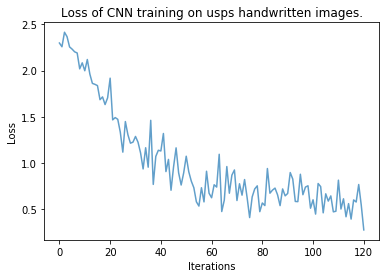

Training accuracy: 0.8416883116883117
Test accuracy: 0.8390909090909091


In [15]:
# Get partially trained USPS model 

# Define the CNN model
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

def train_usps(epochs, model, opt, lossf, train_loader):
    losses,n_itr = [],0
    for e in tqdm(range(epochs)):
        for batch_x, batch_y in train_loader:
            batch_x = Variable(batch_x.cuda()) if use_cuda else Variable(batch_x)
            batch_y = Variable(batch_y.cuda()) if use_cuda else Variable(batch_y)

            result = model(batch_x)
            loss = lossf(result, batch_y)
            opt.zero_grad()
            loss.backward()
            opt.step()

            n_itr+=1
            losses.append(loss)

    if use_cuda:
        losses = [itm.data.cpu().numpy()[0] for itm in losses]
    else:
        losses = [itm.data.numpy()[0] for itm in losses]

    return list(range(n_itr)), losses

# Get raw dataset - USPS
percent_test = 0.3
usps_batch = 64
usps_set = d.get_usps('../notebooks/usps/usps_all.mat', size=(28,28))
usps_x, usps_y, usps_test_x, usps_test_y = al.get_dataset_split(usps_set,int(len(usps_set)*percent_test))
usps_test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_test_x, usps_test_y), \
                                            batch_size=len(usps_test_y),shuffle=False)
usps_train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(usps_x, usps_y), \
                                            batch_size=usps_batch,shuffle=True)
    
# train simple learner on USPS and use as the transfer learner 
usps_epochs = 1
use_cuda = torch.cuda.is_available()
usps_model = CNN().cuda() if use_cuda else CNN()
usps_opt = optim.Adam(usps_model.parameters(), lr=0.01)
usps_loss = nn.NLLLoss()

n_itr, usps_losses = train_usps(1, usps_model, usps_opt, usps_loss, usps_train_loader)

# Analysis of model 
plt.plot(n_itr, usps_losses, alpha=0.7)
plt.title('Loss of CNN training on usps handwritten images.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

print('Training accuracy:',al.accuracy(usps_model, usps_x, usps_y, use_cuda))
print('Test accuracy:',al.accuracy(usps_model, usps_test_x, usps_test_y, use_cuda))

### Now that the transfer learners are loaded we are ready to reinforcement learn:

for a given state of the model.. meaning all potential training points, labeled and unlabeled and our predictions on those, is it better to active learn with policy $y$ and continue training our original model or is it better to transfer a different model and retrain the final layer.


## Implementation: 

I need to implement a system that reinforcement learns two options.  

1. Train more on the source dataset and then perform $n$ epochs of training on the existing points in the target dataset and predict on the validation in the target 
2. Use active learning policies to select the next $k$ points in the target set for labeling and then train for $n$ epochs on the target dataset and predict on the validation set in the target.

##### Decisions:

Decide on if you want the reward to be $\Delta$ accuracy or accuracy itself.

In [5]:
# Make the RL agent to interact with the environment 
class AgentRL(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_policies):
        super(AgentRL, self).__init__()
        self.num_policies = num_policies
        self.inner_layer = nn.Linear(inpt_dim, hidden_dim)
        self.outer_layer = nn.Linear(hidden_dim, num_policies)
        self.rewards = []
        self.saved_log_probs = []
        
    def forward(self, x):
        x = x.view(1,-1)
        x = F.relu(self.inner_layer(x))
        x = self.outer_layer(x)
        return F.softmax(x, dim=1)

In [49]:
rl = imp.reload(rl)
al = imp.reload(al)    
viz = imp.reload(viz)    

tar_costs = [.2,.2,.2,.2,.2,.2,.2,.2]
n_exp = 100
al_itr = 50
pc_all, rwd_all, ac_all = [],[],[]
print(f'Doing {len(tar_costs)} iterations with as many RL learners.')

for tar_c in tar_costs:
    mod = logreg()
    opt = optim.Adam(mod.parameters(),lr=0.01)
    policy_key = {0: 'transfer', 1: 'boundary'}
    agent = AgentRL(int(len(train_x)*10),128, 2) # 2 for the 1 AL policy and one TL policy
    optimizer_rl = optim.Adam(agent.parameters(), lr=1e-2)
    
    rl_e = rl.Environment(mod, train_x, train_y, val_x , val_y,  nn.NLLLoss(), opt, usps_data=usps_train_loader)
    rl_e.set_params(al_itrs=al_itr, npoints=20, batch_size=10)
    pc,rwd,ac = rl_e.run_experiments(agent, optimizer_rl, policy_key, n_experiments=n_exp,  \
                                     tar_cost=tar_c,rtype='transfer')
    pc_all.append(pc)
    rwd_all.append(rwd)
    ac_all.append(ac)

Doing 8 iterations with as many RL learners.


100%|██████████| 100/100 [1:18:06<00:00, 46.86s/it]


In [50]:
import pickle
# Save and load the model
with open("rl_results_lr_tc0.2_gamma0.9.pkl", "wb" ) as file:
    pickle.dump({'policy': pc_all,'reward': rwd_all, 'acc': ac_all},file,protocol=pickle.HIGHEST_PROTOCOL)

with open("rl_results_lr_tc0.2_gamma0.9.pkl",'rb') as file:
    check = pickle.load(file)


Final accuracy over active learning policy: 0.4845


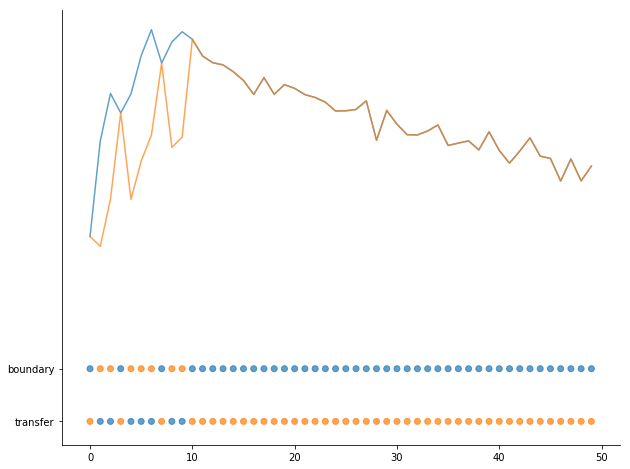

In [70]:
viz = imp.reload(viz)
# Visualize the instance given by 'ii'
experiment = 6
obs_in_exp = 0

viz.viz_rl_tl(check['policy'][experiment],check['acc'][experiment],obs_in_exp,check['reward'][experiment])
print('Final accuracy over active learning policy:',check['acc'][experiment][obs_in_exp][-1])

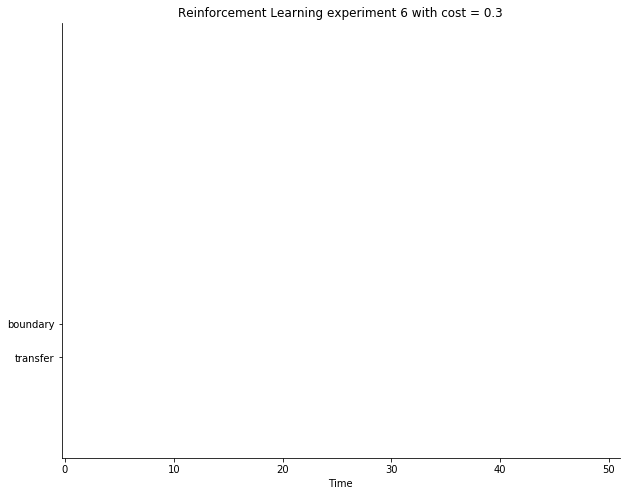

In [84]:



alp = 0.7
experiment = 6
cost = 0.3
gamma = 0.9
labels= ['transfer','boundary']
# cmap = plt.get_cmap('tab10')
# pc = check['policy'][experiment]
# ac = check['acc'][experiment]
# rwd = check['reward'][experiment]

def make_movie(pkl_file, experiment, n_exp, cost, gamma, labels, interval=200, figsize=(10,8),alp=0.7):
    # Get data from pickle file 
    pc = pkl_file['policy'][experiment]
    ac = pkl_file['acc'][experiment]
    rwd = pkl_file['reward'][experiment]
    al_itr = len(pc[0])
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(xlim=[-.3,al_itr+1],ylim=[9.7,11])
    scat_1 = ax.scatter([], [],alpha=alp,animated=True)
    scat_2 = ax.scatter([], [],alpha=alp,animated=True)
    ax.set_yticks([10,10.1])
    ax.set_yticklabels(labels)
    plot_ac, = ax.plot([],[],alpha=alp)
    plot_rd, = ax.plot([],[],alpha=alp)
    ax.set_title(f'Reinforcement Learning experiment {experiment} with cost = {cost}')
    ax.set_xlabel('Time')
    sns.despine()

    # initialization function: plot the background of each frame
    def init():
        scat_1.set_offsets(([], []))
        scat_2.set_offsets(([], []))
        plot_ac.set_data([], [])
        plot_rd.set_data([], [])
        return scat_1,scat_2,plot_ac,plot_rd

    # animation function.  This is called sequentially
    def animate(i):
        me = len(pc[i])
        x_val = np.array(range(me)).reshape(-1,1)
        scat_1y = np.array([10]*me).reshape(-1,1)
        scat_2y = np.array([10.1]*me).reshape(-1,1)
        scat_1.set_array(np.array([1 if j=='transfer' else 0 for j in pc[i]]))
        scat_2.set_array(np.array([1 if j=='boundary' else 0 for j in pc[i]]))
        scat_1.set_offsets(np.append(x_val, scat_1y,axis=1))
        scat_2.set_offsets(np.append(x_val, scat_2y,axis=1))
        plot_ac.set_data(x_val, ac[i,:]+10)
        plot_rd.set_data(x_val, rwd[i,:]+10)

        return scat_1,scat_2,plot_ac,plot_rd

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=n_exp, interval=interval)
    return anim

n_anim = make_movie(check, experiment, n_exp, cost, gamma, labels)
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.save(f'rl_movie_tc{cost}_gamma{0.9}_exp{experiment}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
n_anim.save(f'rl_movie_test.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

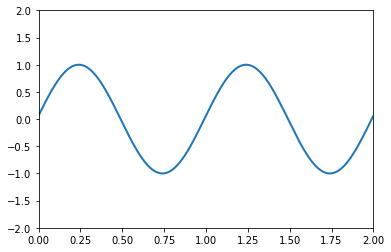

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
animation = imp.reload(animation)
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [7]:
###### OLD #########
rl = imp.reload(rl)
al = imp.reload(al)
viz = imp.reload(viz)

mod = logreg()
opt = optim.Adam(mod.parameters(),lr=0.01)
policy_key = {0: 'transfer', 1: 'boundary'}
agent = AgentRL(int(len(train_x)*10),128, 2) # 2 for the 1 AL policy and one TL policy
optimizer_rl = optim.Adam(agent.parameters(), lr=1e-2)


rl_e = rl.Environment(mod, train_x, train_y, val_x , val_y,  nn.NLLLoss(), opt, usps_data=usps_train_loader)
rl_e.set_params(al_itrs=50, npoints=20, batch_size=10)
pc,rwd,ac = rl_e.run_experiments(agent, optimizer_rl, policy_key, n_experiments=3)


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'torch.FloatTensor'>
<class 'torch.FloatTensor'>
<class 'torch.autograd.variable.Variable'>


 33%|███▎      | 1/3 [00:28<00:56, 28.10s/it]

<class 'torch.FloatTensor'>
<class 'torch.FloatTensor'>
<class 'torch.autograd.variable.Variable'>


 67%|██████▋   | 2/3 [00:56<00:28, 28.19s/it]

<class 'torch.FloatTensor'>
<class 'torch.FloatTensor'>
<class 'torch.autograd.variable.Variable'>


100%|██████████| 3/3 [01:22<00:00, 27.34s/it]


Final accuracy over active learning policy: 0.8838


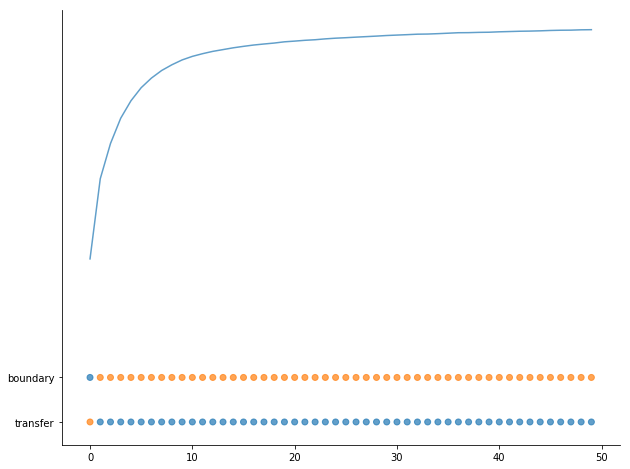

In [104]:
viz = imp.reload(viz)
# Visualize the instance given by 'ii'
ii = 180

viz.viz_rl_tl(pc,ac,ii)
print('Final accuracy over active learning policy:',ac[ii][-1])